# 5.7 使用重复元素的网络（VGG）

AlexNet作者对它们的卷积窗口、输出通道数和构造顺序均做了大量的调整。VGG提出了可以通过重复使用简单的基础块来构建深度模型的思路。

参考文献

[1] Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv preprint arXiv:1409.1556.

## 5.7.1 VGG块

VGG块的组成规律是：连续使用数个相同的填充为1、窗口形状为3×3的卷积层后接上一个步幅为2、窗口形状为2×2的最大池化层。卷积层保持输入的高和宽不变，而池化层则对其减半。我们使用vgg_block函数来实现这个基础的VGG块，它可以指定卷积层的数量和输入输出通道数。

对于给定的感受野（与输出有关的输入图片的局部大小），采用堆积的小卷积核优于采用大的卷积核，因为可以增加网络深度来保证学习更复杂的模式，而且代价还比较小（参数更少）。例如，在VGG中，使用了3个3x3卷积核来代替7x7卷积核，使用了2个3x3卷积核来代替5*5卷积核，这样做的主要目的是在保证具有相同感知野的条件下，提升了网络的深度，在一定程度上提升了神经网络的效果。

In [2]:
import time
import torch
from torch import nn,optim

import sys
sys.path.append("..")
import d2lzh_pytorch as d2l
device=torch.device("cuda" if torch.cuda.is_available() else 'cpu')

def vgg_block(num_convs,in_channels,out_channels):
    blk=[]
    for i in range(num_convs):
        if i==0:#第一层
            blk.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        else:
            blk.append(nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1))
        blk.append(nn.ReLU())
    blk.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*blk)

## 5.7.2 VGG网络

与AlexNet和LeNet一样，VGG网络由卷积层模块后接全连接层模块构成。卷积层模块串联数个vgg_block，其超参数由变量conv_arch定义。该变量指定了每个VGG块里卷积层个数和输入输出通道数。全连接模块则跟AlexNet中的一样。

现在我们构造一个VGG网络。它有5个卷积块，前2块使用单卷积层，而后3块使用双卷积层。第一块的输入输出通道分别是1（因为下面要使用的Fashion-MNIST数据的通道数为1）和64，之后每次对输出通道数翻倍，直到变为512。因为这个网络使用了8个卷积层和3个全连接层，所以经常被称为VGG-11。

#VGG网络可视化：
因为填充为1，所以在卷积层之后的大小不变，在经过池化层后大小减半。
https://dgschwend.github.io/netscope/#/preset/vgg-16

下图中的VGGNet中有五种网络模式，分别为A、B、C、D、E。本文的VGG-Net指的是第一种A，由11层网络。分别是八层的卷积层，再加上三层的全连接层组成。

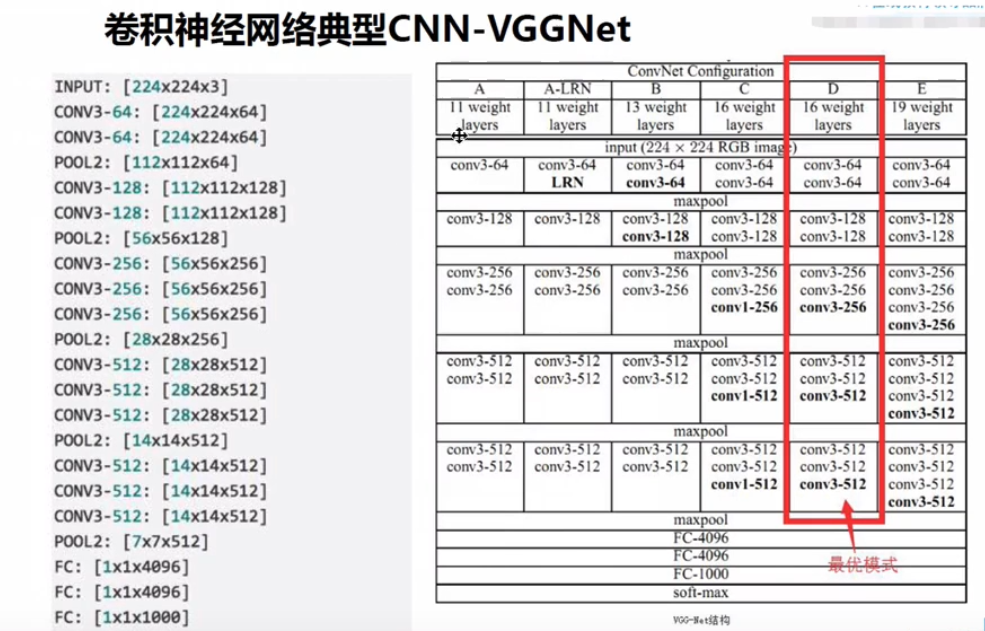

In [4]:
#卷积层模块,5个卷积块，前2块使用单卷积层，而后3块使用双卷积层。
conv_arch=((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
#经过5个vgg_block,宽高会减半5次，变成224/32=7，池化层减半操作
fc_features=512*7*7  #c*w*h
fc_hidden_units=4096

In [5]:
#实现VGG-11
def vgg(conv_arch,fc_features,fc_hidden_units=4096):
    net=nn.Sequential()
    
    for i,(num_convs,in_channels,out_channels)in enumerate(conv_arch):
        # 每经过一个vgg_block都会使宽高减半
        net.add_module("vgg_block_"+str(i+1),vgg_block(num_convs,in_channels,out_channels))
    #全连接层部分
    net.add_module("fc",nn.Sequential(d2l.FlattenLayer(),
                                     nn.Linear(fc_features,fc_hidden_units),
                                     nn.ReLU(),
                                     nn.Dropout(),
                                     nn.Linear(fc_hidden_units,fc_hidden_units),
                                     nn.ReLU(),
                                     nn.Dropout(0.5),
                                     nn.Linear(fc_hidden_units,10)
                                     )
                  )
    return net

In [6]:
# 构造一个高和宽均为224的单通道数据样本来观察每一层的输出形状。
net=vgg(conv_arch,fc_features,fc_hidden_units)
X=torch.rand(1,1,224,224)

# named_children获取一级子模块及其名字(named_modules会返回所有子模块,包括子模块的子模块)
for name,blk in net.named_children():
    X=blk(X)
    print(name,'output shape:',X.shape)

vgg_block_1 output shape: torch.Size([1, 64, 112, 112])
vgg_block_2 output shape: torch.Size([1, 128, 56, 56])
vgg_block_3 output shape: torch.Size([1, 256, 28, 28])
vgg_block_4 output shape: torch.Size([1, 512, 14, 14])
vgg_block_5 output shape: torch.Size([1, 512, 7, 7])
fc output shape: torch.Size([1, 10])


每次我们将输入的高和宽减半，直到最终高和宽变成7后传入全连接层。与此同时，输出通道数每次翻倍，直到变成512。因为每个卷积层的窗口大小一样，所以每层的模型参数尺寸和计算复杂度与输入高、输入宽、输入通道数和输出通道数的乘积成正比。VGG这种高和宽减半以及通道翻倍的设计使得多数卷积层都有相同的模型参数尺寸和计算复杂度。

## 5.7.3 获取数据和训练模型

In [7]:
# 构造一个通道数更小，或者说更窄的网络在Fashion-MNIST数据集上进行训练。

ratio = 8
small_conv_arch = [(1, 1, 64//ratio), (1, 64//ratio, 128//ratio), (2, 128//ratio, 256//ratio), 
                   (2, 256//ratio, 512//ratio), (2, 512//ratio, 512//ratio)]
net = vgg(small_conv_arch, fc_features // ratio, fc_hidden_units // ratio)
print(net)

Sequential(
  (vgg_block_1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (vgg_block_4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
#模型训练
batch_size=64
# 如出现“out of memory”的报错信息，可减小batch_size或resize
train_iter,test_iter=d2l.load_data_fashion_mnist(batch_size,resize=224,root='../Datasets/FashionMNIST')

lr,num_epochs=0.001,5
optimizer=torch.optim.Adam(net.parameters(),lr=lr)
d2l.train_ch5(net,train_iter,test_iter,batch_size,optimizer,device,num_epochs)